# Multinomial Classification - BMI 예제

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

## Data Preprocessing

In [9]:
df = pd.read_csv('data/bmi.csv', skiprows=3)
display(df.head(), df.shape)

,label,height,weight
0,1,188,71
1,2,161,68
2,0,178,52
3,2,136,63
4,1,145,52


(20000, 3)

### 결측치 처리

In [10]:
df.isnull().sum()

label     0
height    0
weight    0
dtype: int64

### 이상치 처리

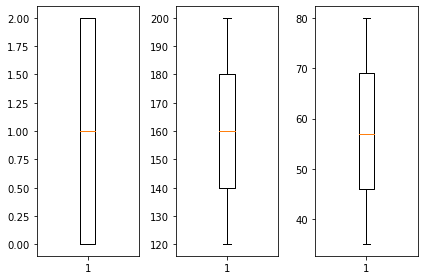

In [12]:
# 이상치 확인
fig = plt.figure()
fig_1 = fig.add_subplot(1,3,1)
fig_2 = fig.add_subplot(1,3,2)
fig_3 = fig.add_subplot(1,3,3)

fig_1.boxplot(df['label'])
fig_2.boxplot(df['height'])
fig_3.boxplot(df['weight'])

fig.tight_layout()
plt.show()

### Training Data Set
* x_data: 정규화 필요
* t_data: One-hot Encoding을 통해 1차원 ndarray 벡터를 2차원 Matrix 형태로 변환 필요

In [23]:
x_data = df[['height', 'weight']].values 
t_data = df['label'].values # [0 1 2 0]
                            # [[1 0 0]
                            #  [0 1 0]
                            #  [0 0 1]
                            #  [1 0 0]]

### 정규화

In [16]:
scaler_x = MinMaxScaler()
scaler_x.fit(x_data)
norm_x_data = scaler_x.transform(x_data)
print(norm_x_data)

[[0.85       0.8       ]
 [0.5125     0.73333333]
 [0.725      0.37777778]
 ...
 [0.375      0.28888889]
 [0.8625     0.75555556]
 [0.275      0.13333333]]


### One Hot Encoding
`t_data`가 One-Hot Encoding을 통해 0과 1로 표현되므로 정규화는 따로 진행하지 않는다.

In [18]:
sess = tf.Session()
norm_t_data = sess.run(tf.one_hot(t_data, depth=3))
print(norm_t_data)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


## Softmax Regression
### Splitting Train Data Set and Validation Data Set
* 7: Training Data Set
* 3: Validation Data Set

In [32]:
print(norm_x_data.shape)
train_x_data = norm_x_data[:int(norm_x_data.shape[0] * 0.7)]
val_x_data = norm_x_data[int(norm_x_data.shape[0] * 0.7):]
print(train_x_data.shape)
print(val_x_data.shape)

train_t_data = norm_t_data[:int(norm_t_data.shape[0] * 0.7)]
val_t_data = norm_t_data[int(norm_t_data.shape[0] * 0.7):]
print(train_t_data.shape)
print(val_t_data.shape)

(20000, 2)
(14000, 2)
(6000, 2)
(14000, 3)
(6000, 3)


### Tensorflow

In [28]:
# X, T
X = tf.placeholder(shape=[None, 2], dtype=tf.float32) # 2: height, weight
T = tf.placeholder(shape=[None, 3], dtype=tf.float32) # one hot encoding 형태

# W, b
W = tf.Variable(tf.random.normal([2,3]), name='weight')
b = tf.Variable(tf.random.normal([3]), name='bias')

# Hypothesis
logit = tf.matmul(X, W) + b
H = tf.nn.softmax(logit) # Softmax Activation Function 이용

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# learning
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], feed_dict={X: train_x_data, T: train_t_data})
    
    if step % 30000 == 0:
        print('W: {}, b: {}, loss: {}'.format(W_val, b_val, loss_val))

W: [[-0.67463857 -1.9429342  -0.12502177]
 [-0.7373367   2.2779624   0.07409472]], b: [1.1049906  0.49366945 1.8601496 ], loss: 1.302871823310852
W: [[-0.31386057 -1.7986933  -0.63004327]
 [-0.75120556  2.2259724   0.13982594]], b: [1.3765496  0.55694294 1.5253286 ], loss: 1.0780881643295288
W: [[-0.10332865 -1.6932299  -0.9460024 ]
 [-0.856741    2.1401417   0.33114934]], b: [1.410454   0.55980444 1.4884598 ], loss: 1.0060088634490967
W: [[ 0.06157038 -1.5948296  -1.2093787 ]
 [-0.97649723  2.0605118   0.5306257 ]], b: [1.3886305 0.5651728 1.5050019], loss: 0.9500958323478699
W: [[ 0.20836285 -1.5028306  -1.448202  ]
 [-1.0923095   1.9894315   0.71795785]], b: [1.3564636 0.5743165 1.5289505], loss: 0.9026251435279846
W: [[ 0.34396926 -1.417843   -1.668883  ]
 [-1.2007043   1.924429    0.8913635 ]], b: [1.324277  0.5853474 1.5504541], loss: 0.8619250655174255
W: [[ 0.47151005 -1.3400524  -1.8742121 ]
 [-1.3016464   1.8653208   1.0516372 ]], b: [1.2920905 0.5978644 1.5702351], loss: 0.8

### Model Accuracy
예측한 확률에서 가장 높은 확률값

In [29]:
predict = tf.argmax(H, axis=1)
correct = tf.equal(predict, tf.argmax(T, axis=1)) 
for_acc = tf.cast(correct, dtype=tf.float32) 

# Accuracy
accuracy = tf.reduce_mean(for_acc)
accuracy_val = sess.run(accuracy, feed_dict={X: val_x_data, T: val_t_data})

print('모델의 정확도: {}'.format(accuracy_val)) # 80%

모델의 정확도: 0.7946666479110718


### Prediction

In [30]:
height = 187
weight = 78
my_state = [[height, weight]]

result = sess.run(H, feed_dict={X: scaler_x.transform(my_state)})
print(result) # 정상, [0: 저체중, 1: 정상, 2: 과체중]

[[0.1841997  0.47624972 0.33955067]]
